# Environment setup

In [18]:
# Install packages from pip
#!pip install cellxgene_census datasets scanpy igraph leidenalg accelerate scvi-colab

In [2]:
# To install geneformer we have to clone the git repo first
#!git lfs install
#!git clone https://huggingface.co/ctheodoris/Geneformer
#%cd Geneformer
#!pip install .
#%cd ..

# Models download

Models hosted on https://cellxgene.cziscience.com/census-models normally require Amazon Web Services (AWS) to download. Since aws-cli is not installed on google colab I have temporarily loaded them to dropbox.  

In [1]:
# Download and extract geneformer model
!wget 'https://www.dropbox.com/scl/fi/4edmbf7fik0q8kzyq2pef/fine_tuned_geneformer.tar.gz?rlkey=v0ux8v9a3qe8il6o7bowxep8c&st=6ar0ptjg&dl=0' -O fine_tuned_geneformer.tar.gz
!tar -xzf fine_tuned_geneformer.tar.gz

--2025-07-04 10:47:57--  https://www.dropbox.com/scl/fi/4edmbf7fik0q8kzyq2pef/fine_tuned_geneformer.tar.gz?rlkey=v0ux8v9a3qe8il6o7bowxep8c&st=6ar0ptjg&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc946b0a91fdfbb7966b9353e58.dl.dropboxusercontent.com/cd/0/inline/Cs1DAm3Ni7AYO9RPQouR7KWFgcaw6-buCd3mny1Fyw2Ic22pwimHKvhuJIV3zj9Fp-OHWxSkNSjzSuIw3SFoxwbFNQQ5T7AbAO_ziB_Nis0Q6etZW763HRQ_INqz-HNTyweVkHc0A9gxvRpIaiwpVDFs/file# [following]
--2025-07-04 10:47:57--  https://ucc946b0a91fdfbb7966b9353e58.dl.dropboxusercontent.com/cd/0/inline/Cs1DAm3Ni7AYO9RPQouR7KWFgcaw6-buCd3mny1Fyw2Ic22pwimHKvhuJIV3zj9Fp-OHWxSkNSjzSuIw3SFoxwbFNQQ5T7AbAO_ziB_Nis0Q6etZW763HRQ_INqz-HNTyweVkHc0A9gxvRpIaiwpVDFs/file
Resolving ucc946b0a91fdfbb7966b9353e58.dl.dropboxusercontent.com (ucc946b0a91fdfbb7966b9353e58.dl.dropboxuser

In [5]:
!ls fine_tuned_geneformer

cell_subclass_to_label.json  label_to_cell_subclass.json  training_args.bin
config.json		     model.safetensors
eval_metrics.json	     test_errors.tsv


# Data download

In [2]:
# Download and extract pbmc data

!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2025-07-04 10:48:27 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


In [3]:
# Dowload gene list
! wget 'https://www.dropbox.com/scl/fi/brauikmesjfworl67cxov/cpdb_genelist.csv?rlkey=55ankib03njbf9tkci8tgzqc6&st=ezcv94sg&dl=0' -O cpdb_genelist.csv

--2025-07-04 10:48:31--  https://www.dropbox.com/scl/fi/brauikmesjfworl67cxov/cpdb_genelist.csv?rlkey=55ankib03njbf9tkci8tgzqc6&st=ezcv94sg&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc591df67e70098c5644ca648273.dl.dropboxusercontent.com/cd/0/inline/Cs1UsM-VAT9hjh2ZavwmF47dtpPaGrfEl7W54wErMTvQmvgv8UJe0RXe8GYZFzjP2coOWZP6dW_Q0vrR1yJH9WFf31osCweCnZCat2o36KfE6Uvs8UL1yZXguLfRiImC3aSRNHouzI3alcEepV7Gzn0g/file# [following]
--2025-07-04 10:48:31--  https://uc591df67e70098c5644ca648273.dl.dropboxusercontent.com/cd/0/inline/Cs1UsM-VAT9hjh2ZavwmF47dtpPaGrfEl7W54wErMTvQmvgv8UJe0RXe8GYZFzjP2coOWZP6dW_Q0vrR1yJH9WFf31osCweCnZCat2o36KfE6Uvs8UL1yZXguLfRiImC3aSRNHouzI3alcEepV7Gzn0g/file
Resolving uc591df67e70098c5644ca648273.dl.dropboxusercontent.com (uc591df67e70098c5644ca648273.dl.dropboxusercontent.com

# Geneformer for cell class prediction and data projection

This notebook provides examples to utilize the CELLxGENE collaboration fine-tuned Geneformer model with user data. For more information on the model please refer to the [Census model page](https://cellxgene.cziscience.com/census-models).

**IMPORTANT:** This tutorial requires cellxgene-census package version 1.9.1 or later.

**Contents**

1. Requirements.
1. Preparing data and model.
1. Using the Geneformer fine-tuned model for **cell subclass inference**.
1. Using the Geneformer fine-tuned model for **data projection**.

> ⚠️ Note "cell subclass" is a high-level grouping of cell types as annotated in CELLxGENE Discover via the CL ontology see [https://cellxgene.cziscience.com/collections](https://cellxgene.cziscience.com/collections

> ⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

### Downloading the fine-tuned Geneformer model

### Importing required packages

Finally all the required packages are loaded.

In [4]:
import warnings

warnings.filterwarnings("ignore")

import json
import os

#import cellxgene_census
import datasets
import numpy as np
import scanpy as sc
from geneformer import DataCollatorForCellClassification
from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from transformers import BertForSequenceClassification, Trainer

from torch import set_float32_matmul_precision
set_float32_matmul_precision('medium')

## Preparing data and model

### Preparing single-cell data

Let's load the test data. In preparation to use with Geneformer we do the following:

- Set the index as the ENSEMBL gene ID and stores it in the `obs` column `"ensembl_id"`
  - e.g. `ENSG00000139618` (*without* a version number suffix)
- Add read counts to the `obs` column `"n_counts"`
- Add an ID column to be used for joining later in the  `obs` column `"joinid"`

Then we write the resulting H5AD file to disk.

In [5]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "./data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)

adata.write(h5ad_dir + "pbmcs.h5ad")

Now we can tokenize the test data using Geneformer's tokenizer, while keeping track of `"joinid"` for future joining.

In [6]:
token_dir = "data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)

tokenizer = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"})
tokenizer.tokenize_data(
    data_directory=h5ad_dir,
    output_directory=token_dir,
    output_prefix="pbmc",
    file_format="h5ad",
)

Tokenizing data/h5ad/pbmcs.h5ad
data/h5ad/pbmcs.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2700 [00:00<?, ? examples/s]

### Preparing data from model

Then let's fetch the mapping dictionary between Geneformer IDs and the associated cell subclass labels. This information is stored along the fine-tuned model.

In [11]:
model_dir = "./fine_tuned_geneformer/"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file) as fp:
    label_mapping_dict = json.load(fp)

This dictionary contains all the possible cell labels available for the model, and the predictions on the section below will use these labels.

In [12]:
for k in list(label_mapping_dict.keys())[:5]:
    print(k, ': ', label_mapping_dict[k])

0 :  B cell
1 :  BEST4+ intestinal epithelial cell, human
2 :  CD4-positive, alpha-beta T cell
3 :  CD8-positive, alpha-beta T cell
4 :  CNS neuron (sensu Vertebrata)


## Using the Geneformer fine-tuned model for cell subclass inference

### Loading tokenized data

Let's load the tokenized test data.

In [16]:
dataset = datasets.load_from_disk(token_dir + "pbmc.dataset")
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length'],
    num_rows: 2700
})

We add a dummy cell metadata column `"label"` needed for Geneformer to make predictions.

In [17]:
dataset
dataset = dataset.add_column("label", [0] * len(dataset))

### Performing inference of cell subclass

Now we can load the model and run the inference workflow.

> ⚠️ Note, this step will be slow with CPUs, a machine with one GPU is recommended

In [18]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification())
# use trainer
predictions = trainer.predict(dataset)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


And finally we select the most likely cell class based on the probability vector from the predictions of each cell in our test data.

In [19]:
predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_logits = [predictions.predictions[i][predicted_label_ids[i]] for i in range(len(predicted_label_ids))]
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

### Inspecting inference results

Then we add the prediction back to our loaded AnnData test dataset.

In [20]:
adata.obs["predicted_cell_subclass"] = predicted_labels
adata.obs["predicted_cell_subclass_probability"] = np.exp(predicted_logits) / (1 + np.exp(predicted_logits))

And it's ready for inspecting the predictions. Let's visualize the predictions on the UMAP space, the following is a basic processing workflow to derive a UMAP representation, of the data.

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

Let's also add the original cell type annotations as obtained in [Scapy's annotation tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of the same data.

In [22]:
sc.tl.leiden(adata)
original_cell_types = [
    "CD4-positive, alpha-beta T cell (1)",
    "CD4-positive, alpha-beta T cell (2)",
    "CD14-positive, monocyte",
    "B cell (1)",
    "CD8-positive, alpha-beta T cell",
    "FCGR3A-positive, monocyte",
    "natural killer cell",
    "dendritic cell",
    "megakaryocyte",
    "B cell (2)",
]
adata.rename_categories("leiden", original_cell_types)

These are the original annotations.

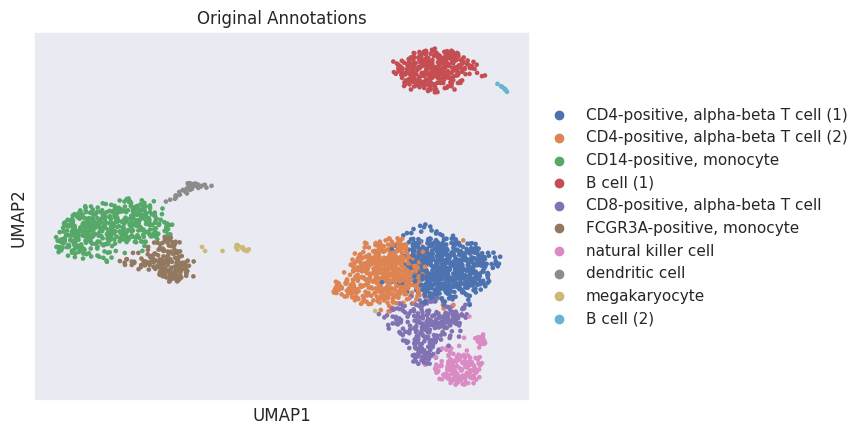

In [23]:
sc.pl.umap(adata, color="leiden", title="Original Annotations")

And these are the predicted annotations.

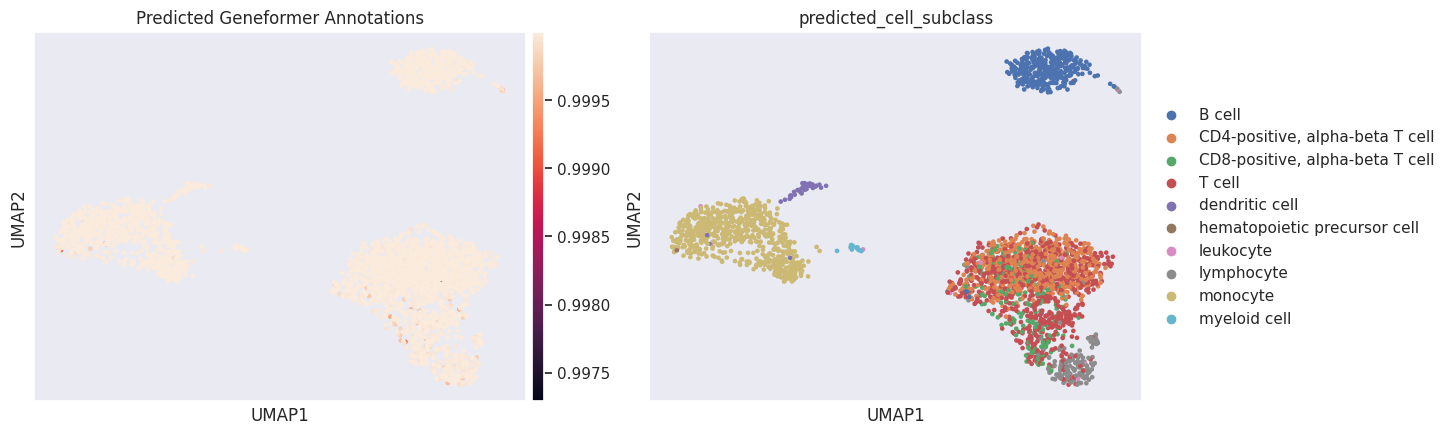

In [24]:
sc.pl.umap(
    adata,
    color=["predicted_cell_subclass_probability", "predicted_cell_subclass"],
    title="Predicted Geneformer Annotations",
)

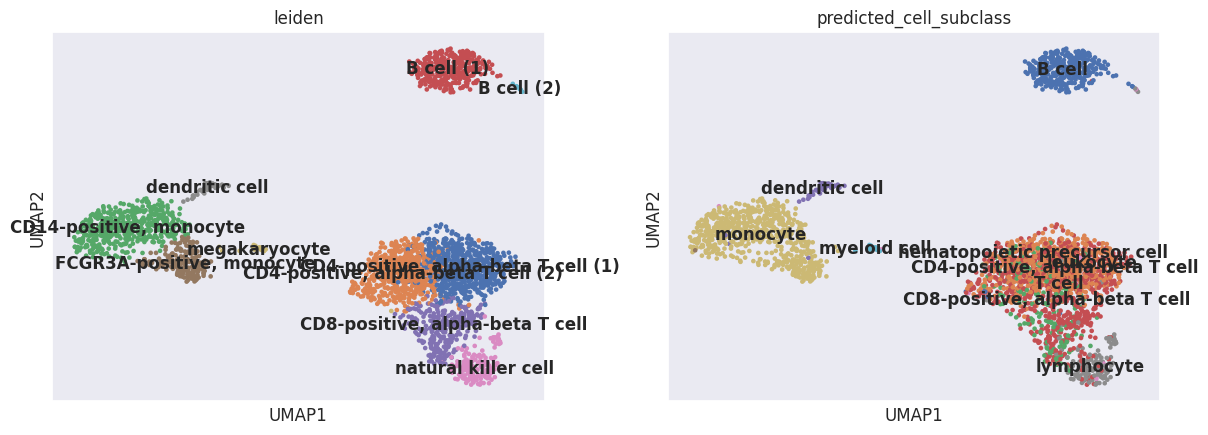

In [25]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_cell_subclass"],
    legend_loc = 'on data'
)

## Using the Geneformer fine-tuned model for data projection

### Generating Geneformer embeddings for 10X PBMC 3K data

To project new data, for example the 10X PBMC 3K data, into the Census embedding space from Geneformer's fine-tune model, we can use `EmbExtractor` from the [Geneformer](https://huggingface.co/ctheodoris/Geneformer) package as follows.

We first need to get the number of categories (cell subclasses) present in the model.

In [26]:
n_classes = len(label_mapping_dict)

Then we can run the `EmbExtractor`, which randomize the cells during the process and thus we keep track of `"joinid"`.

> ⚠️ Note, this step will be slow with CPUs, a machine with one GPU is recommended

In [27]:
output_dir = "data/geneformer_embeddings"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    max_ncells=None,
    emb_label=["joinid"],
    emb_layer=0,
    forward_batch_size=30,
    nproc=8,
)

embs = embex.extract_embs(
    model_directory=model_dir,
    input_data_file=token_dir + "pbmc.dataset",
    output_directory=output_dir,
    output_prefix="emb",
)

  0%|          | 0/90 [00:00<?, ?it/s]

In [28]:
!ls data/geneformer_embeddings



emb.csv


Then we simply re-order the embeddings based on `"joinid"` and then merge them to the original AnnData

In [29]:
embs = embs.sort_values("joinid")
adata.obsm["geneformer"] = embs.drop(columns="joinid").to_numpy()

Let's take a look at these Geneformer embeddings in a UMAP representation

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata)

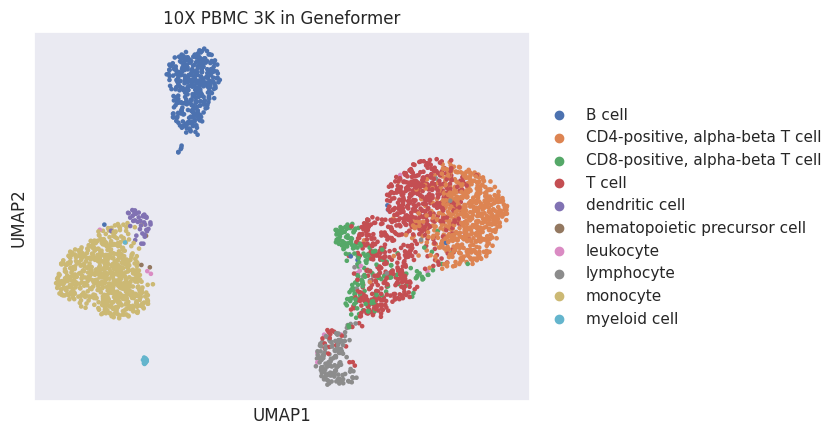

In [31]:
sc.pl.umap(adata, color="predicted_cell_subclass", title="10X PBMC 3K in Geneformer")

### Joining Geneformer embeddings from 10X PBMC 3K data with other Census datasets

There are multiple datasets in Census from PBMCs, and all human Census data has pre-calculated Geneformer embeddings, so now we can join the embeddings we generated above from the 10X PBMC 3K dataset with Census data.

Let's grab a few PBMC datasets from Census and request the Geneformer embeddings.

In [3]:
import cellxgene_census

In [ ]:
# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e

dataset_ids = [
    "fa8605cf-f27e-44af-ac2a-476bee4410d3",
    "3c75a463-6a87-4132-83a8-c3002624394d",
]

with cellxgene_census.open_soma(census_version="2023-12-15") as census:

    adata_census = cellxgene_census.get_anndata(
        census=census,
        measurement_name="RNA",
        organism="Homo sapiens",
        obs_value_filter=f"dataset_id in {dataset_ids}",
        obs_embeddings=["geneformer"],
  )

To simplify let's select the genes that are also present in the 10X PBMC 3K dataset.

In [28]:
adata_census.var_names = adata_census.var["feature_id"]
shared_genes = list(set(adata.var_names) & set(adata_census.var_names))
adata_census = adata_census[:, shared_genes]

And take a subset of these cells, let's take 3K cells to match the size of the test data.

In [29]:
index_subset = np.random.choice(adata_census.n_obs, size=3000, replace=False)
adata_census = adata_census[index_subset, :]

Now we can join these Census data to the 10X PBMC 3K data

In [30]:
adata_census.obs["dataset"] = "Census - " + adata_census.obs["dataset_id"].astype(str)
adata.obs["dataset"] = "10X PBMC 3K"
adata.obs["cell_type"] = "Predicted - " + adata.obs["predicted_cell_subclass"].astype(str)

adata_joined = sc.concat([adata, adata_census], join="outer", label="batch")

Let's now inspect all of the cells in the UMAP space.

In [31]:
sc.pp.neighbors(adata_joined, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata_joined)

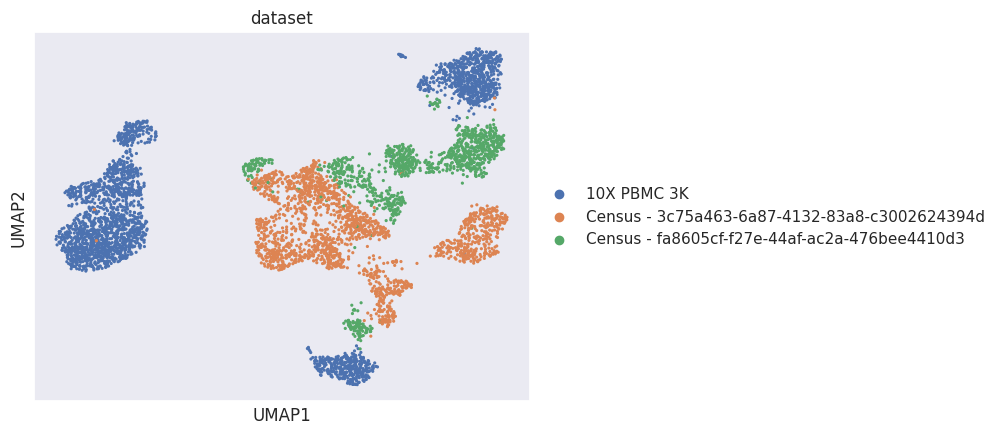

In [32]:
sc.pl.umap(adata_joined, color="dataset")

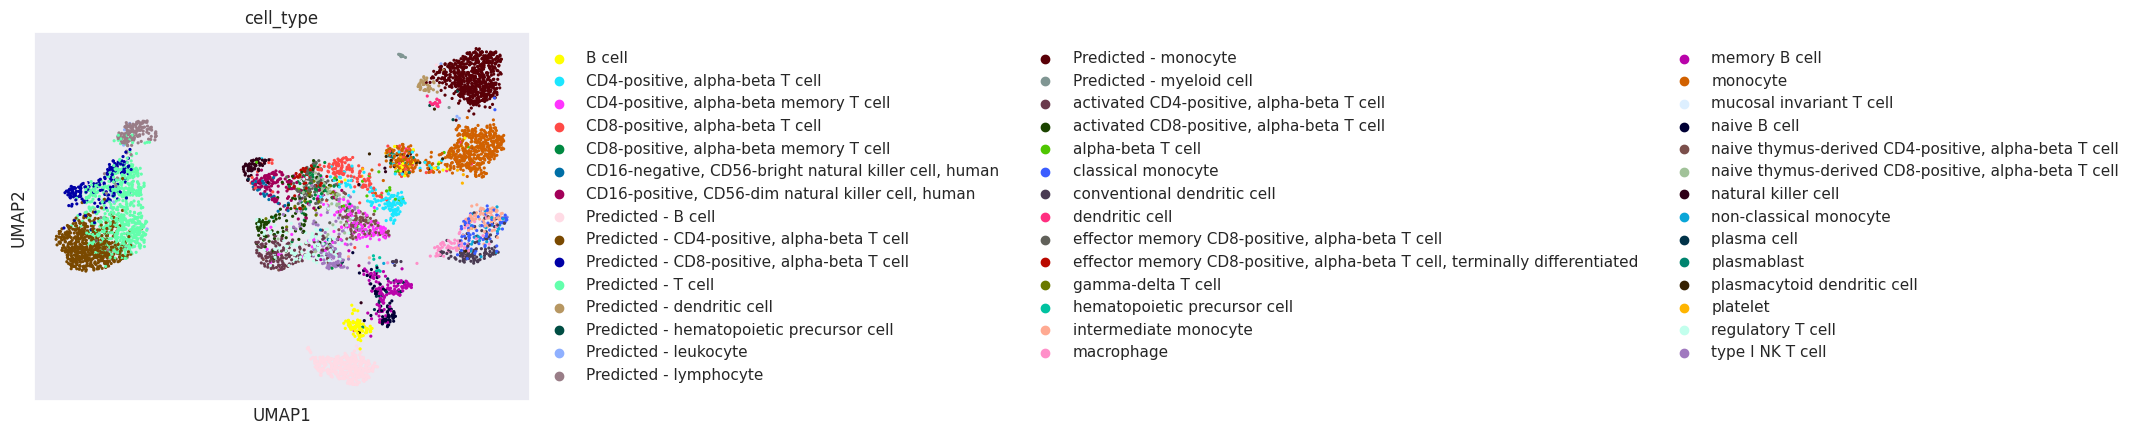

In [33]:
sc.pl.umap(adata_joined, color="cell_type")